In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
# KNN search map
from sklearn.manifold import TSNE
import scipy.io as sio
import os
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F

In [173]:
# load cub data        
data_dir = 'data/cub_googlenet/'
f = sio.loadmat(data_dir+'train_cub_googlenet_bn.mat')
train_feature = np.array(f['train_cub_googlenet_bn'])
print('train feature:', train_feature.shape)
f = sio.loadmat(data_dir+'train_label.mat')
train_label = np.squeeze(np.array(f['label']))
print('train label:', train_label)

print('train id:', np.unique(train_label))
f = sio.loadmat(data_dir+'test_cub_googlenet_bn.mat')
test_feature = np.array(f['test_cub_googlenet_bn'])
print('test feature:', test_feature .shape)

f = sio.loadmat(data_dir+'test_proto.mat')
test_att = np.array(f['test_proto'])
print('test att:', test_att.shape)

f = sio.loadmat(data_dir+'test_labels_cub.mat')
test_label = np.squeeze(np.array(f['test_labels_cub']))-1
print('test label:', test_label) #2933

f = sio.loadmat(data_dir+'testclasses_id.mat')
test_classid = np.squeeze(np.array(f['testclasses_id']))-1
print('test classid:', test_classid)




train feature: (8855, 1024)
train label: [  1   1   1 ... 199 199 199]
train id: [  1   2   4   6   9  10  11  12  14  15  16  17  18  19  20  21  23  24
  25  26  27  29  31  38  39  40  41  43  44  45  46  47  49  51  53  54
  55  56  57  58  59  60  61  62  63  64  66  67  68  69  70  72  73  74
  75  76  77  79  80  81  84  86  87  88  89  91  92  93  96  98  99 103
 104 105 106 107 108 109 110 112 114 115 116 117 119 121 122 123 124 125
 126 127 128 130 131 132 133 135 136 138 139 140 141 142 143 144 145 147
 148 149 150 151 152 153 154 156 157 158 159 160 161 163 166 167 168 169
 170 171 172 173 174 175 176 177 178 180 181 183 187 188 189 190 191 192
 193 194 195 197 198 199]
test feature: (2933, 1024)
test att: (50, 312)
test label: [  0   0   0 ... 196 196 196]
test classid: [  0   3   5   7   8  13  22  28  30  32  33  34  35  36  37  42  48  50
  52  65  71  78  82  83  85  90  94  95  97 100 101 102 111 113 118 120
 129 134 137 146 155 162 164 165 179 182 184 185 186 196]


In [179]:
train_f = []
test_f = []
train_l = []
test_l = []
train_d = {}
test_d = {}
new_features = []
new_labels = []
ind = 0
for l in np.unique(train_label):
    index = np.where(l==train_label)
    if len(new_features) == 0:
        new_features = train_feature[index]
    else:
        new_features = np.vstack((new_features, train_feature[index]))
    new_labels.extend([ind]*len(index[0]))
    ind += 1
    
for l in np.unique(test_label):
    index = np.where(l==test_label)
    new_features = np.vstack((new_features, test_feature[index]))
    new_labels.extend([ind]*len(index[0]))    
    ind += 1


In [239]:
train_features = []
train_labels = []

test_feature_unseen = []
test_label_unseen = []

new_labels = np.array(new_labels)

for i in range(200):
    index = np.where(i==new_labels)[0]
    if i in train_label_unique:
        if len(train_features) == 0:
            train_features = new_features[index]
        else:
            train_features = np.vstack((train_features, new_features[index]))
            
        train_labels.extend([i]*len(index))
    else:
        if len(test_feature_unseen) == 0:
            test_feature_unseen = new_features[index]
        else:
            test_feature_unseen = np.vstack((test_feature_unseen, new_features[index]))
        test_label_unseen.extend([i]*len(index))

train_labels = np.array(train_labels)
test_label_unseen = np.array(test_label_unseen)

In [240]:

#np.random.seed(42)
#permutation随机生成0-len(data)随机序列
shuffled_indices = np.random.permutation(len(train_features))
#test_ratio为测试集所占的半分比
test_set_size = int(len(train_features)* 0.2) 
test_indices = shuffled_indices[:test_set_size]
train_indices = shuffled_indices[test_set_size:]
#iloc选择参数序列中所对应的行
train_feature, train_label = train_features[train_indices], train_labels[train_indices]
test_feature_seen, test_label_seen = train_features[test_indices], train_labels[test_indices]

In [248]:
sio.savemat('data/CUB_data/googlenet.mat',{
    'original_att': attribute,
    'train_feature':train_feature,
    'train_label':train_label,
    'test_feature_unseen':test_feature_unseen,
    'test_label_unseen':test_label_unseen,
    'test_feature_seen':test_feature_seen,
    'test_label_seen':test_label_seen,    
})

In [202]:
# load train data        
data_dir = 'data/CUB_data/'
mat_visual = sio.loadmat(os.path.join(data_dir, "res101.mat"))
features, labels = mat_visual[
    'features'].T, mat_visual['labels'].astype(int).squeeze() - 1

mat_semantic = sio.loadmat(
    os.path.join(data_dir, "att_splits.mat"))
trainval_loc = mat_semantic['trainval_loc'].squeeze() - 1
test_seen_loc = mat_semantic['test_seen_loc'].squeeze() - 1
test_unseen_loc = mat_semantic['test_unseen_loc'].squeeze() - 1

attribute1 = mat_semantic['original_att'].T  # manual labeld attributes

attribute = attribute1

train_feature = features[trainval_loc]  # feature
train_label = labels[trainval_loc].astype(
    int)  # 23527 training samples。
train_att = attribute[train_label]  # 23527*85
train_label_unique = np.unique(train_label)

test_feature_unseen = features[test_unseen_loc]  # 7913 测试集中的未见类
test_label_unseen = labels[test_unseen_loc].astype(int)

test_feature_seen = features[test_seen_loc]  # 5882  测试集中的已见类
test_label_seen = labels[test_seen_loc].astype(int)

test_id_unseen = np.unique(test_label_unseen)
test_att_map_unseen = attribute[test_id_unseen]


In [2]:
# load train data        
data_dir = 'data/AWA2_data/'
mat_visual = sio.loadmat(os.path.join(data_dir, "res101.mat"))
features, labels = mat_visual[
    'features'].T, mat_visual['labels'].astype(int).squeeze() - 1

mat_semantic = sio.loadmat(
    os.path.join(data_dir, "att_splits.mat"))
trainval_loc = mat_semantic['trainval_loc'].squeeze() - 1
test_seen_loc = mat_semantic['test_seen_loc'].squeeze() - 1
test_unseen_loc = mat_semantic['test_unseen_loc'].squeeze() - 1

attribute1 = mat_semantic['original_att'].T  # manual labeld attributes

attribute = attribute1

train_feature = features[trainval_loc]  # feature
train_label = labels[trainval_loc].astype(
    int)  # 23527 training samples。
train_att = attribute[train_label]  # 23527*85
train_label_unique = np.unique(train_label)

test_feature_unseen = features[test_unseen_loc]  # 7913 测试集中的未见类
test_label_unseen = labels[test_unseen_loc].astype(int)

test_feature_seen = features[test_seen_loc]  # 5882  测试集中的已见类
test_label_seen = labels[test_seen_loc].astype(int)

test_id_unseen = np.unique(test_label_unseen)
test_att_map_unseen = attribute[test_id_unseen]

array([[-0.00375358, -0.00375358, -0.00375358, ...,  0.00882092,
         0.03640974,  0.03145501],
       [ 0.12045618,  0.00426584,  0.        , ...,  0.17996306,
         0.0618086 ,  0.03495531],
       [ 0.26584459,  0.20652363,  0.        , ...,  0.05026822,
         0.04274552,  0.04915256],
       ...,
       [ 0.22516498,  0.15266022,  0.        , ...,  0.12733492,
         0.10009694,  0.01771   ],
       [ 0.19613947,  0.1966714 ,  0.        , ...,  0.01787277,
         0.06698743,  0.25883601],
       [ 0.03819588,  0.08046548,  0.10363715, ...,  0.01479997,
         0.05250999,  0.14194515]])

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
class Softmax(object):
    def __init__(self, tr_x, tr_y):
        self.n_cla = len(np.unique(tr_y))
        self.classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=self.n_cla, max_iter=200)
        self.classifier.fit(tr_x, tr_y.squeeze())
        
    def acc(self, tt_x, tt_y):
        tt_y = tt_y.squeeze()
        predict = self.classifier.predict(tt_x)
        acc = np.zeros(len(np.unique(tt_y)))
        for i,j in zip(range(tt_y.max() + 1), np.unique(tt_y)):
            acc[i] = (predict[tt_y == j] == j).mean()  # 取每个类的平均准确率，再平均
        acc = acc.mean() * 100
                
        acc2 = (predict==tt_y).mean()
        return acc

    
#x_train,x_test, y_train, y_test = train_test_split(features, labels,test_size=0.2, random_state=0)
x_train,x_test, y_train, y_test = train_test_split(test_feature_unseen, test_label_unseen,test_size=0.2, random_state=0)

In [29]:
g_a = np.load('data/AWA2_data/class_attribute_map.npy')
g_attribute = np.hstack((P.scale(attribute, axis=1), P.scale(g_a)))

In [30]:
g_attribute

array([[-0.83993286, -0.83993286, -0.83993286, ..., -0.63211501,
         0.23897247, -0.63260029],
       [ 0.60490223, -0.80758678, -0.8594452 , ..., -0.66776406,
         0.52607105, -0.91351841],
       [ 2.31627567,  1.6308533 , -0.75541834, ..., -0.85051097,
         1.45239181, -0.05770131],
       ...,
       [ 1.91391574,  0.9912819 , -0.95134237, ..., -0.58052282,
         0.69160697,  0.44865049],
       [ 1.52855678,  1.5350854 , -0.87876218, ..., -0.4734417 ,
        -1.31855669, -0.55776841],
       [-0.31272209,  0.17527483,  0.44278861, ...,  0.50595629,
        -0.06488572, -0.66881109]])

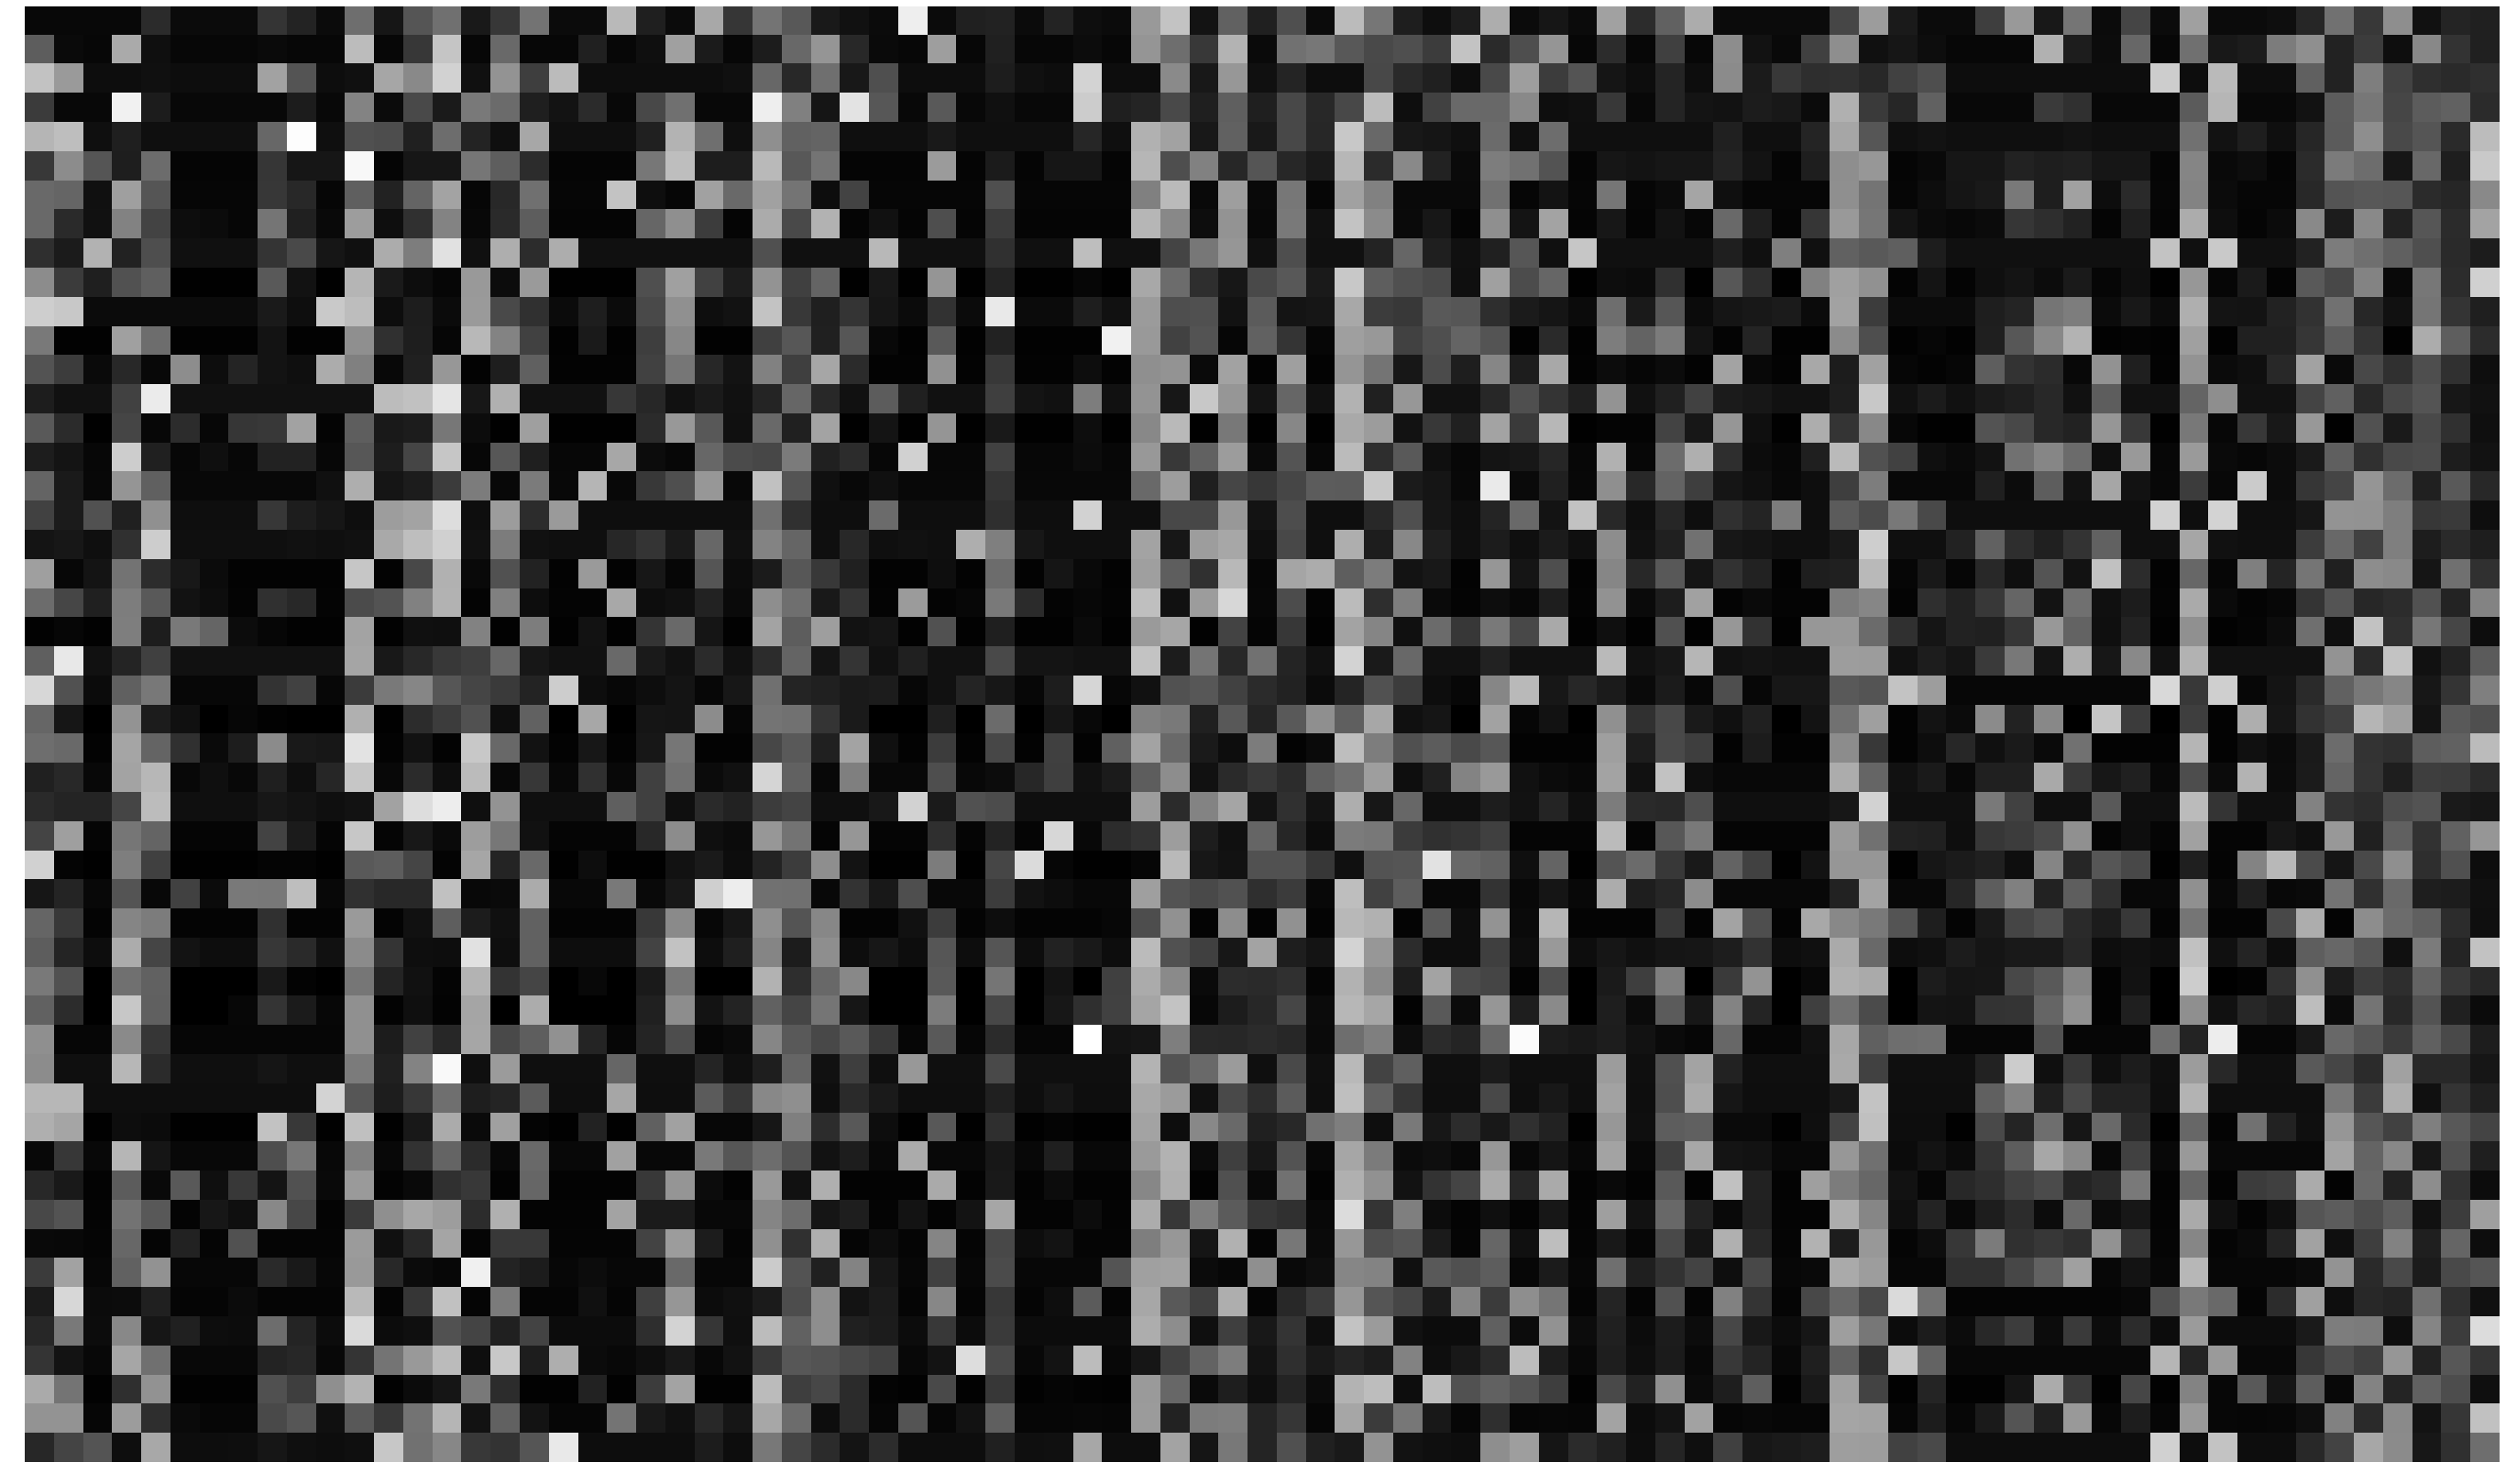

In [36]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import preprocessing as P
plt.figure(figsize=(50, 50))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
#设置标注前后左右的距离
plt.imshow(P.scale(attribute, axis=1), interpolation='nearest', cmap='gist_gray' )
#plt.xlabel('attribute')
#plt.ylabel('class')
#plt.colorbar()
plt.axis('off')  #去掉坐标轴
#plt.title('Attribute Distribution Heatmap \nafter Processing of Our Model.',fontsize=20)
plt.show()


In [15]:
g_attribute.shape

(50, 235)

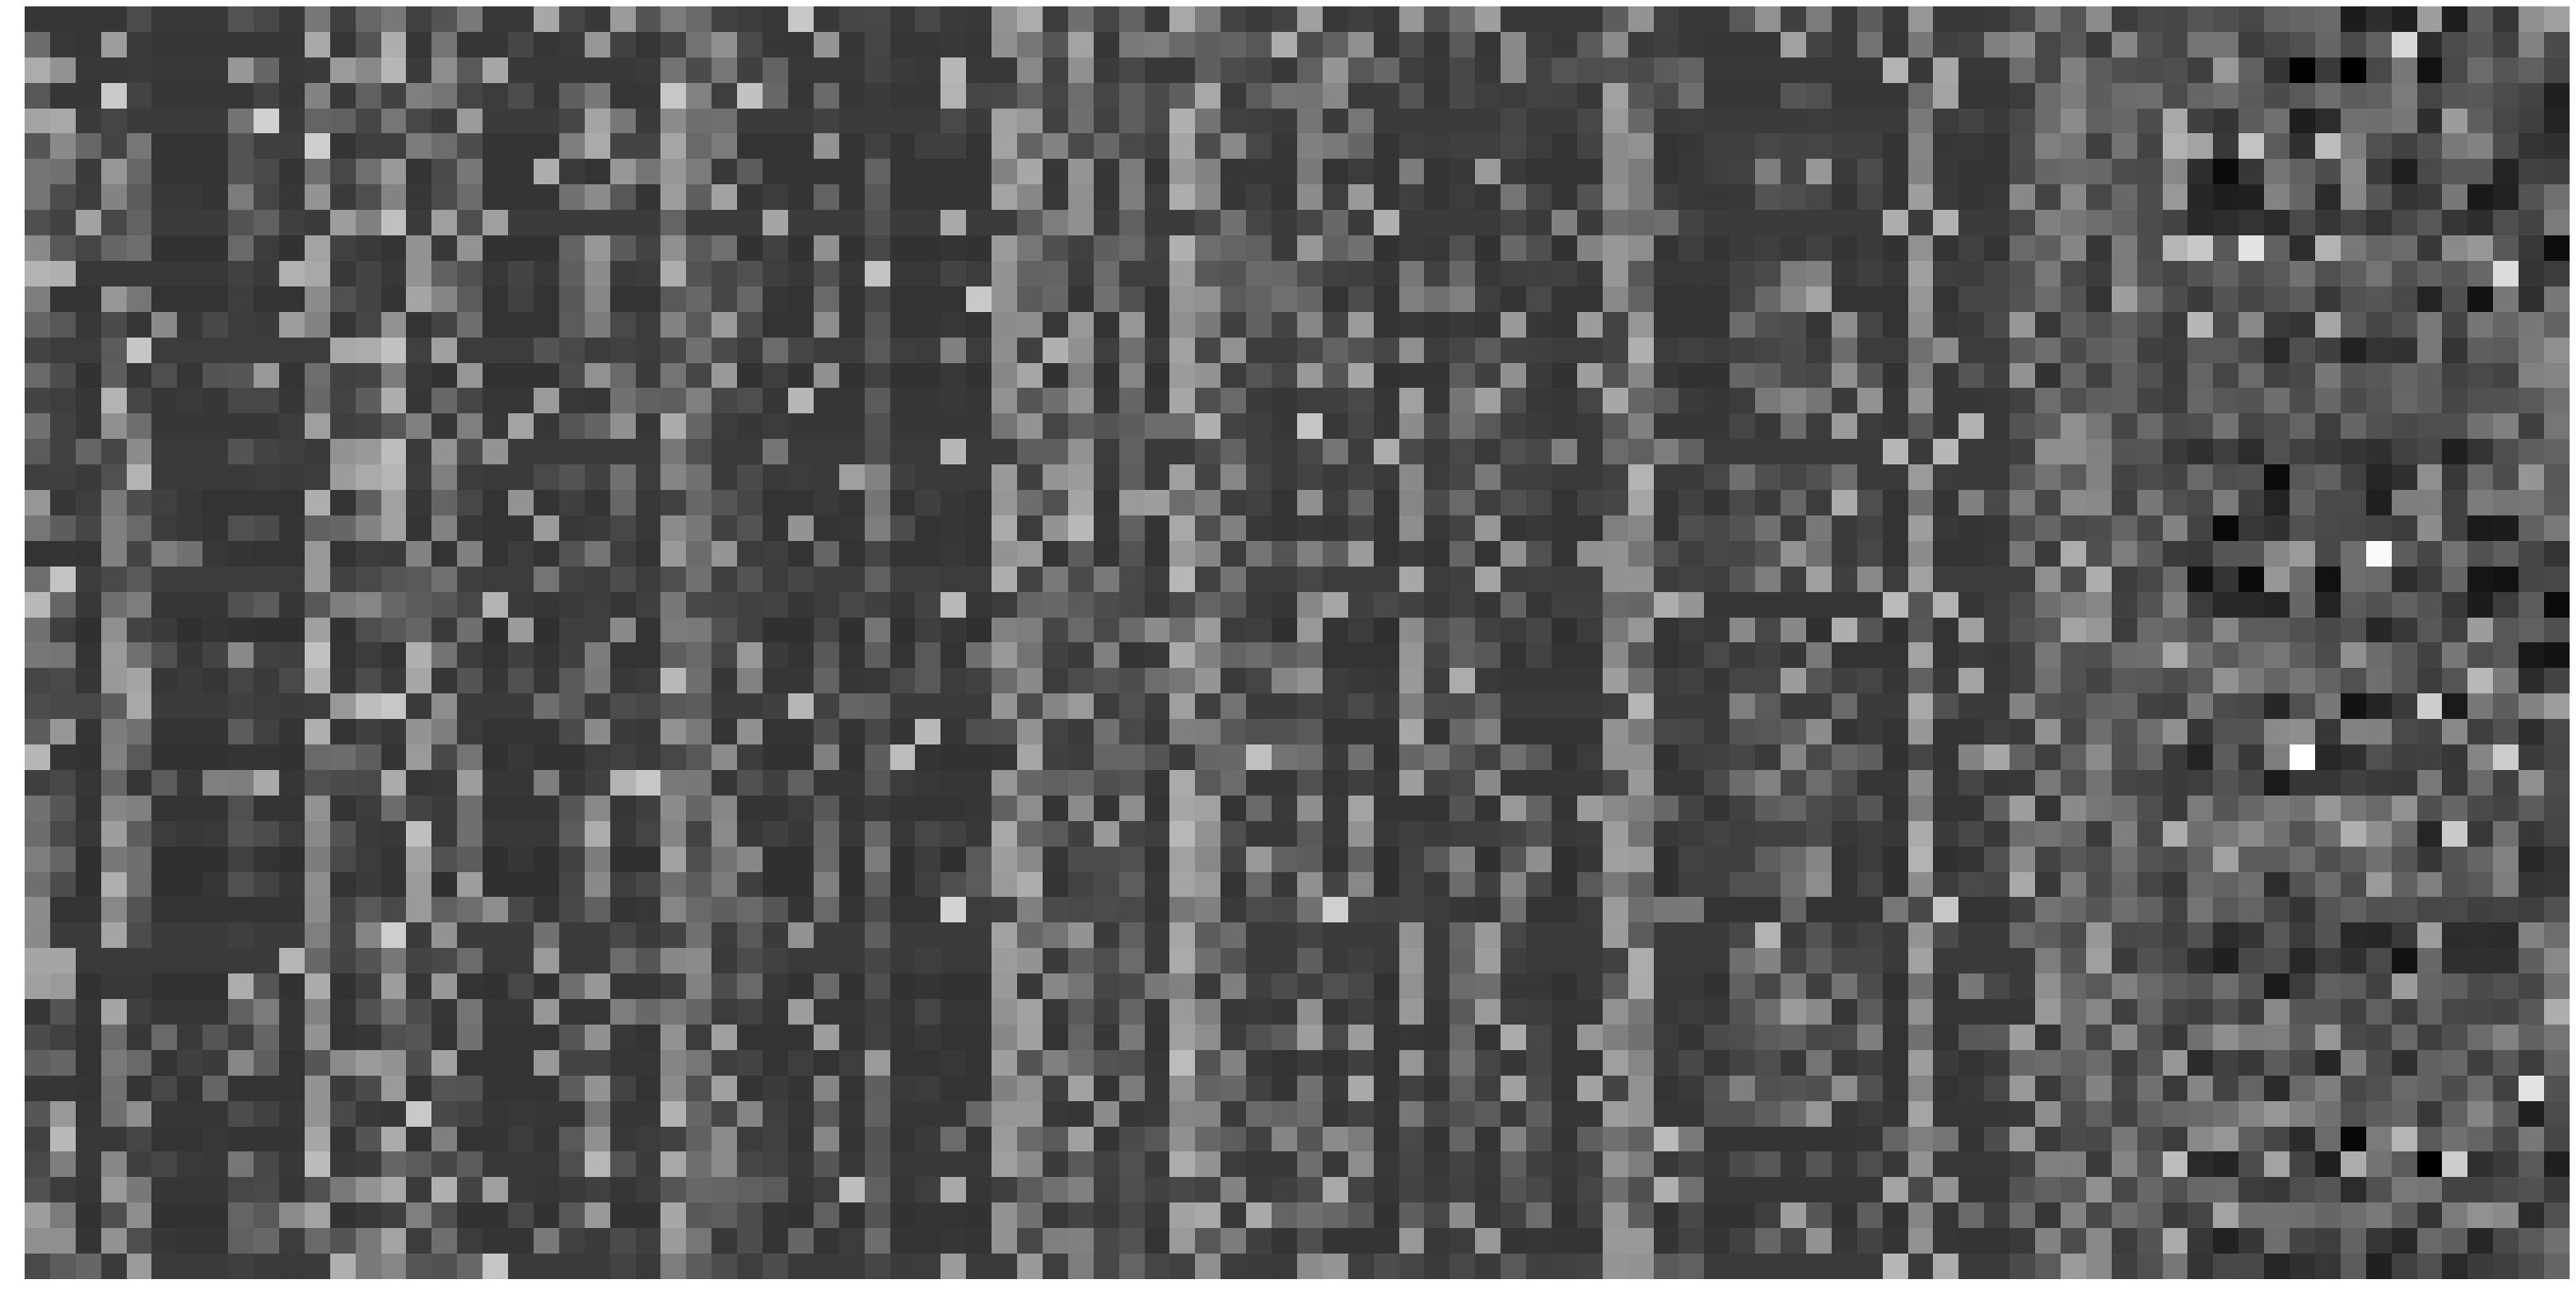

In [38]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import preprocessing as P
plt.figure(figsize=(50, 50))
#设置标注前后左右的距离
plt.imshow(g_attribute[:,:100], interpolation='nearest', cmap='gist_gray' )
#plt.xlabel('attribute')
#plt.ylabel('class')
#plt.colorbar()
plt.axis('off')  #去掉坐标轴
#plt.title('Attribute Distribution Heatmap \nafter Processing of Our Model.',fontsize=20)
plt.show()


In [5]:
class MyModel(nn.Module):
    def __init__(self, attr_dim, output_dim):
        super(MyModel, self).__init__()
        self.attr_dim = attr_dim
        self.output_dim = output_dim
        
        channel_num = 10
        self.conv1 = nn.Conv2d(1, 50, kernel_size=1)
        self.conv2 = nn.Conv2d(1, channel_num, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(channel_num)
        self.conv_out_dim = 50 * (attr_dim)*channel_num
        self.fc = nn.Linear(self.conv_out_dim, self.output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 
        x = x.view(-1, 1, 50, self.attr_dim)  # batch, channel, height , width
        x = F.relu(self.bn1(self.conv2(x)))
        #x = x.view(-1, 50, 50, self.attr_dim)  
        #x = torch.mean(x, dim=1) # average the feature map

        x = x.view(-1, self.conv_out_dim)  # flatten

        x = self.fc(x)

        return x    

    
class CenterLoss(nn.Module):
    """Center loss.

    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.

    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """

    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(
                torch.randn(self.num_classes, self.feat_dim).cuda()
            )
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = (
            torch.pow(x, 2)
            .sum(dim=1, keepdim=True)
            .expand(batch_size, self.num_classes)
            + torch.pow(self.centers, 2)
            .sum(dim=1, keepdim=True)
            .expand(self.num_classes, batch_size)
            .t()
        )

        classes = torch.arange(self.num_classes).long()

        if self.use_gpu:
            distmat = distmat.cuda()
            classes = classes.cuda()

        distmat.addmm_(
            1, -2, x, self.centers.t()
        )  # 1*distmat + (-2)*(x*self.centers'T)

        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)

        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e12).sum() / batch_size

        return loss

# 将visual feature在center loss影响下进行映射，让visual更为紧凑
class LinearModel(nn.Module):
    def __init__(self, feat_dim):
        super(LinearModel, self).__init__()

        self.fc1 = nn.Linear(feat_dim, feat_dim)
        self.fc2 = nn.Linear(feat_dim, feat_dim)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))  # 
        x = self.fc2(x)  

        return x  

In [6]:
lamb = 1e-5
cl_path = 'output/AWA2/CenterLoss_Beta-{}_GenAttr-0.pth'
model_path = 'output/AWA2/Model_Beta-{}_GenAttr-0.pth'

cl = CenterLoss(num_classes=50, feat_dim=2048)
model = MyModel(attr_dim=85, output_dim=2048)
cl.load_state_dict(torch.load(cl_path.format(lamb)))
model.load_state_dict(torch.load(model_path.format(lamb)))

model = model.cuda()
input = torch.tensor(test_att_map_unseen).float().reshape(-1, 1, 1, 85).cuda()
input_attr = torch.tensor(attribute).float().reshape(-1, 1, 1, 85).cuda()
unseen_semantic = model(input).cpu().detach().numpy()
all_semantic = model(input_attr).cpu().detach().numpy()

centers = cl.centers.cpu().detach().numpy()
unseen_centers = centers[test_id_unseen]

In [3]:
# MED Model : visual -> att. 2048 -> 85 on AwA2
class MedModel(nn.Module):
    def __init__(self, attr_dim, visual_dim):
        super(MedModel, self).__init__()
        self.in_dim = visual_dim
        self.output_dim = attr_dim
        
        self.expand_num = 5
        self.conv1 = nn.Conv2d(1, 5, kernel_size=1)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1)

        self.conv_out_dim = 6138
        self.fc1 = nn.Linear(self.conv_out_dim, 1024)
        self.fc2 = nn.Linear(1024, self.output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # ret:10*2048
        x = x.view(-1, 1, self.expand_num, self.in_dim)  # batch, channel, height , width
        x = F.relu(self.conv2(x))
        #x = x.view(-1, 50, 50, self.attr_dim)  
        #x = torch.mean(x, dim=1) # average the feature map

        x = x.view(-1, self.conv_out_dim)  # flatten

        x = self.fc2(F.relu(self.fc1(x)))

        return x    
    

In [ ]:
# load train data        
data_dir = 'data/AWA2_data/'
mat_visual = sio.loadmat(os.path.join(data_dir, "res101.mat"))
features, labels = mat_visual[
    'features'].T, mat_visual['labels'].astype(int).squeeze() - 1

mat_semantic = sio.loadmat(
    os.path.join(data_dir, "att_splits.mat"))
trainval_loc = mat_semantic['trainval_loc'].squeeze() - 1
test_seen_loc = mat_semantic['test_seen_loc'].squeeze() - 1
test_unseen_loc = mat_semantic['test_unseen_loc'].squeeze() - 1

attribute1 = mat_semantic['original_att'].T  # manual labeld attributes

attribute = attribute1

train_feature = features[trainval_loc]  # feature
train_label = labels[trainval_loc].astype(
    int)  # 23527 training samples。
train_att = attribute[train_label]  # 23527*85
train_label_unique = np.unique(train_label)

test_feature_unseen = features[test_unseen_loc]  # 7913 测试集中的未见类
test_label_unseen = labels[test_unseen_loc].astype(int)

test_feature_seen = features[test_seen_loc]  # 5882  测试集中的已见类
test_label_seen = labels[test_seen_loc].astype(int)

test_id_unseen = np.unique(test_label_unseen)
test_att_map_unseen = attribute[test_id_unseen]

In [7]:
lamb = 1e-5
model_path = 'output/AWA2/MedModel.pth'

model = MedModel(85, 2048)
model.load_state_dict(torch.load(model_path))

model = model.cuda()

train_feat = model(torch.from_numpy(train_feature).view(-1, 1, 1, 2048).float().cuda()).detach().cpu().numpy()
test_feat_seen = model(torch.from_numpy(test_feature_seen).view(-1, 1, 1, 2048).float().cuda()).detach().cpu().numpy()
test_feat_unseen = model(torch.from_numpy(test_feature_unseen).view(-1, 1, 1, 2048).float().cuda()).detach().cpu().numpy()


In [18]:
# 检验seen class的相似度 based on semantic output
sapce_dim = 40  # shape[0] stands for the num of classes to be decice
target_label = []
label_predict = {i:[] for i in range(50)}
for feat, real_label in zip(test_feature_seen, test_label_seen):
    diff = np.tile(feat, (sapce_dim, 1)) - all_semantic[train_label_unique]   # Subtract element-wise
    squaredDiff = diff ** 2  # squared for the subtract
    squaredDist = np.sum(squaredDiff, axis=1)  # sum is performed by row
    distance = squaredDist ** 0.5

    max_index = np.argsort(distance)
    label = int(train_label_unique[max_index[0]])
    target_label.append(label)
    label_predict[real_label].append(label)
    
#     if real_label in [23, 29, 49]:
#         print('real_label:', real_label)
#         print('predict:', label, distance[max_index[0]], test_id_unseen[max_index[1]], distance[max_index[1]], test_id_unseen[max_index[2]], distance[max_index[2]])
    
# print(target_label)
# print(test_label_unseen)
print("total zsl:", np.sum(target_label == test_label_seen)/test_label_seen.shape[0])
for key in train_label_unique:
    lis = label_predict[key]
    print(key, np.sum(lis==key), np.sum(lis==key)/len(lis), len(lis))

#  1e-5-0.87929, 1e-6-0.38, 1e-8-0.2286

total zsl: 0.8792927575654539
0 166 0.9120879120879121 182
1 144 0.8888888888888888 162
2 41 0.6833333333333333 60
3 32 0.7804878048780488 41
4 104 0.9719626168224299 107
5 133 0.8986486486486487 148
7 187 0.8577981651376146 218
9 83 0.83 100
10 30 0.967741935483871 31
11 22 0.88 25
12 174 0.9942857142857143 175
13 125 0.8865248226950354 141
14 152 1.0 152
15 109 0.7266666666666667 150
16 38 0.7037037037037037 54
17 137 0.9513888888888888 144
18 185 0.9788359788359788 189
19 150 0.9202453987730062 163
20 120 0.8571428571428571 140
21 118 0.9516129032258065 124
24 133 0.8209876543209876 162
25 129 0.9280575539568345 139
26 226 0.9456066945606695 239
27 114 0.8444444444444444 135
28 201 0.95260663507109 211
31 111 0.9327731092436975 119
32 93 0.7815126050420168 119
34 16 0.32 50
35 130 0.7831325301204819 166
36 187 0.949238578680203 197
37 228 1.0 228
38 181 0.9945054945054945 182
39 219 0.7963636363636364 275
41 126 0.8129032258064516 155
42 190 0.9595959595959596 198
43 8 0.2 40
44 182

In [353]:
# 检验out_semantic的相似度 on unseen class
sapce_dim = 10  # shape[0] stands for the num of classes to be decice
target_label = []
label_predict = {i:[] for i in test_id_unseen}
wrong_pre = {
    23:[],
    29:[],
    46:[],
}

for feat, real_label in zip(test_feature_unseen, test_label_unseen):
    diff = np.tile(feat, (sapce_dim, 1)) - all_semantic[test_id_unseen]  # Subtract element-wise
    squaredDiff = diff ** 2  # squared for the subtract
    squaredDist = np.sum(squaredDiff, axis=1)  # sum is performed by row
    distance = squaredDist ** 0.5

    max_index = np.argsort(distance)
    label = test_id_unseen[max_index[0]]
    target_label.append(label)
    label_predict[real_label].append(label)
    
    if real_label in [23, 29, 46]:  # 被误分类最多的 ： 23->46 , 29->33  , 46->23
        #print('real_label:', real_label)
        #print('predict:', label, distance[max_index[0]], test_id_unseen[max_index[1]], distance[max_index[1]], test_id_unseen[max_index[2]], distance[max_index[2]])
        wrong_pre[real_label].append(label)
# print(target_label)
# print(test_label_unseen)
print("total zsl:", np.sum(target_label == test_label_unseen)/test_label_unseen.shape[0])
for key , lis in label_predict.items():
    print(key, round(np.sum(lis==key)/len(lis), 5), len(lis) )

# lamda 0-0.704, 0.0001-0.696, 1e-5-0.73928, 1e-6-0.6869, 1e-8-0.726

# from collections import Counter
# Counter(wrong_pre[23])

total zsl: 0.7392897763174523
6 0.91672 1645
8 0.98276 174
22 0.81901 1420
23 0.6417 988
29 0.08355 383
30 0.75541 1202
33 0.94839 310
40 0.91111 630
46 0.30233 215
49 0.5296 946


In [377]:
# 距离class29 最近的特征
target = 29
class29 = all_semantic[target]

diff = test_feature_unseen - np.tile(class29, (test_feature_unseen.shape[0],1))  # Subtract element-wise
squaredDiff = diff ** 2  # squared for the subtract
squaredDist = np.sum(squaredDiff, axis=1)  # sum is performed by row
distance = squaredDist ** 0.5

max_index = np.argsort(distance)
label = test_label_unseen[max_index]
for ind, i in enumerate(max_index):
    print(ind, test_label_unseen[i], distance[i])
#     if test_label_unseen[i] == target:
#         print(ind, test_label_unseen[i], distance[i])


0 40 22.22279345514934
1 40 22.459614490532157
2 33 22.491191475072323
3 40 22.6877562936263
4 40 22.839174423051293
5 22 22.855041551108602
6 22 23.103790676058736
7 40 23.23517630603201
8 22 23.316175681207753
9 40 23.333600908156857
10 40 23.364182459102334
11 22 23.42103006283673
12 22 23.46833335666585
13 40 23.548748314425296
14 40 23.586017524118645
15 40 23.62220914732881
16 22 23.659560090896925
17 40 23.83018564514143
18 22 23.835379155047054
19 40 23.856141681770243
20 40 23.86907897672097
21 22 23.910543140991535
22 22 23.917648322018177
23 40 23.977579577994774
24 40 23.992516819070254
25 40 23.995658529322423
26 22 24.00693187599118
27 40 24.028828351910512
28 22 24.039166975431655
29 22 24.058964403522666
30 33 24.077499580197262
31 40 24.129069594655725
32 22 24.150539163752406
33 40 24.153056537455313
34 22 24.22682645908608
35 22 24.237419543773605
36 40 24.23973137802224
37 22 24.247617924462627
38 40 24.249775871347875
39 30 24.2804977030096
40 22 24.291076555517147

1843 30 31.539629181563427
1844 30 31.54039805167981
1845 6 31.542600791944686
1846 6 31.546205026960397
1847 30 31.54622472571822
1848 30 31.547156264750036
1849 6 31.5492270500595
1850 6 31.549235085934694
1851 23 31.55210354487117
1852 33 31.553187757995964
1853 33 31.55548155126726
1854 6 31.557725667512475
1855 23 31.558372650235274
1856 29 31.55924223381454
1857 40 31.560094968947336
1858 6 31.56912328664355
1859 30 31.573143077107858
1860 6 31.57340654139758
1861 23 31.573732321043167
1862 6 31.574888997537077
1863 22 31.578876411559417
1864 30 31.582207810591406
1865 6 31.583347251506304
1866 23 31.586735072664514
1867 30 31.588207376598636
1868 6 31.597107093647107
1869 6 31.597821753007107
1870 6 31.598657093957694
1871 6 31.598707602742632
1872 22 31.59895561677639
1873 22 31.602495190025035
1874 22 31.602779395714634
1875 22 31.60640221129793
1876 40 31.606897563101295
1877 22 31.614848622358522
1878 30 31.615233399531803
1879 29 31.626311747475814
1880 22 31.62764238117310

3770 6 35.38926588699675
3771 6 35.38955903071135
3772 23 35.39127715550055
3773 29 35.39365595713401
3774 6 35.393831927753205
3775 29 35.39433908453709
3776 30 35.39726325218215
3777 22 35.40146022894358
3778 22 35.41116463225886
3779 22 35.411345273816146
3780 22 35.41338299219209
3781 22 35.41664155394202
3782 46 35.41807798788477
3783 30 35.422352053153766
3784 30 35.42252535346459
3785 6 35.42463073852375
3786 29 35.43133339199582
3787 22 35.43151989847557
3788 6 35.43345489325342
3789 6 35.43509328822778
3790 6 35.43592372274319
3791 30 35.43704984433355
3792 6 35.43956667074929
3793 30 35.440135052630566
3794 46 35.443601195896754
3795 29 35.449778402143075
3796 30 35.45131795653074
3797 49 35.45768549524839
3798 30 35.45992235408217
3799 6 35.461931929031174
3800 30 35.46427301946713
3801 22 35.46651818343526
3802 30 35.46706683452665
3803 46 35.46941606275747
3804 30 35.47216350500849
3805 6 35.47227644077299
3806 23 35.47301966195932
3807 6 35.473535593193965
3808 6 35.47519

5603 6 39.19366026162932
5604 33 39.19743616133923
5605 8 39.19743775343427
5606 23 39.2028964674034
5607 29 39.20655669683647
5608 23 39.20813206464716
5609 8 39.21238163027259
5610 33 39.21604471542511
5611 30 39.219858650132515
5612 6 39.22146600449385
5613 49 39.22277083966327
5614 6 39.223490053415986
5615 30 39.22540048297173
5616 49 39.22543090172078
5617 46 39.22583085971764
5618 30 39.22651122055493
5619 6 39.22935829709026
5620 22 39.23065215231478
5621 6 39.23182761306104
5622 6 39.232370518649056
5623 6 39.23274608585294
5624 49 39.23696488630567
5625 49 39.236977690460364
5626 49 39.24029388884055
5627 23 39.24128617619099
5628 49 39.24479284307423
5629 30 39.24561337558303
5630 30 39.251348449518595
5631 22 39.252030104909736
5632 22 39.257092822838175
5633 6 39.26343941053736
5634 22 39.265966710148035
5635 23 39.26848485195885
5636 30 39.270085600597724
5637 23 39.27255656785526
5638 23 39.28165611422969
5639 29 39.28199747595601
5640 22 39.282563541989404
5641 22 39.28

6770 8 42.543127925654694
6771 6 42.545430320495775
6772 49 42.548400412711956
6773 49 42.549296642077735
6774 6 42.5528975064158
6775 6 42.558113467858576
6776 6 42.56035424410774
6777 6 42.56066299683964
6778 49 42.56160112466639
6779 49 42.56356232496118
6780 29 42.56376800032516
6781 49 42.56385380297057
6782 6 42.568230382146055
6783 29 42.56974658541162
6784 49 42.57296872237444
6785 33 42.574518622459536
6786 6 42.577516143172495
6787 33 42.57807540999125
6788 49 42.580818751775645
6789 22 42.5889233475842
6790 8 42.59003853174439
6791 23 42.605282204261755
6792 23 42.605631548339815
6793 22 42.60669819187449
6794 6 42.61477088641024
6795 6 42.6172133596068
6796 46 42.61974652352999
6797 23 42.62130499670237
6798 49 42.62343555229299
6799 29 42.62644444499744
6800 23 42.628700203281426
6801 49 42.629291238516174
6802 8 42.635229674069215
6803 29 42.638096918388754
6804 49 42.645162537366204
6805 40 42.64692082324754
6806 49 42.647851422985156
6807 49 42.65170416713532
6808 6 42.

In [8]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100, random_state=0)
# tsne = TSNE()
train_feat_tsne = tsne.fit_transform(train_feat)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100, random_state=0)
# tsne = TSNE()
test_feat_unseen_tsne = tsne.fit_transform(test_feat_unseen)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100, random_state=0)
test_feat_seen_tsne = tsne.fit_transform(test_feat_seen)


In [15]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100, random_state=0)
att_tsne = tsne.fit_transform(attribute)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100, random_state=0)
att2_tsne = tsne.fit_transform(att2)

Text(0.5, 1.0, 'Visual->Semantic. Star(*): centers')

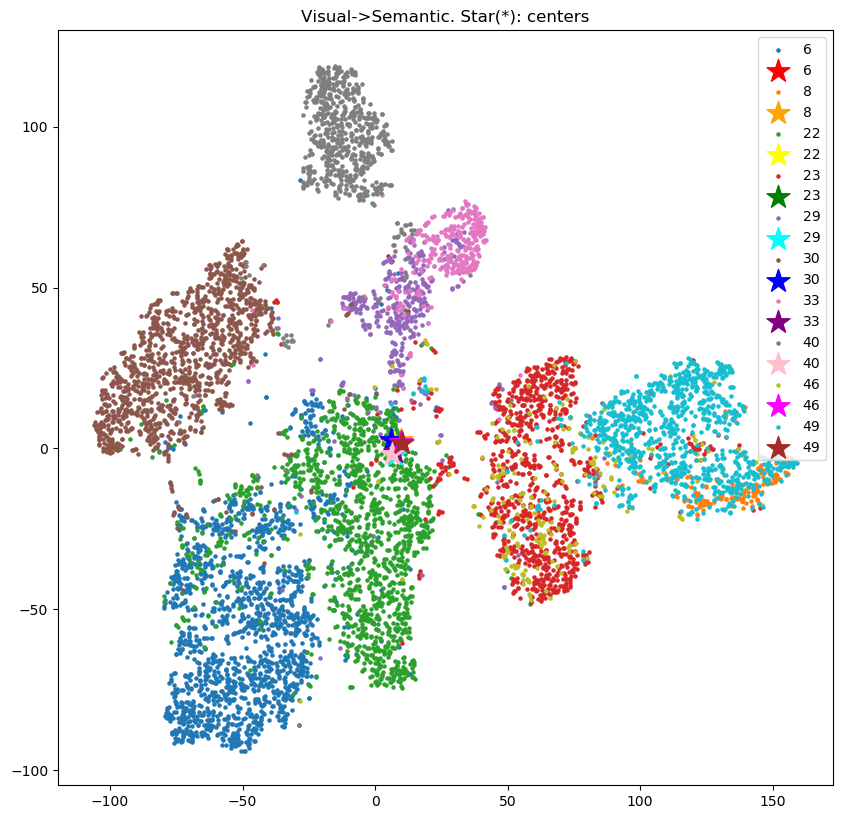

In [29]:
# unseen class tsne
 #tsne.embedding_
postfix = 'Visual->Semantic'
plt.figure(figsize=(10, 10),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
# plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
for index, cla in enumerate(test_id_unseen):
    class_index = np.where(test_label_unseen == cla)[0].tolist()

    plt.scatter(test_feat_unseen_tsne[class_index,0], test_feat_unseen_tsne[class_index,1],   s=5, label=cla)
    plt.scatter(att2_tsne[cla,0], att2_tsne[cla,1],  c=cs[index], s=300, marker='*', label=cla)
    
plt.legend() 
plt.title('Visual->Semantic. Star(*): centers')
# plt.savefig(f'figure/figure{postfix}.png')
    #plt.annotate(test_id_unseen[i], xy = (vec_tsne[i][0], vec_tsne[i][1]), xytext = (vec_tsne[i][0]+0.1, vec_tsne[i][1]+0.1))



In [25]:
test_id_unseen

array([ 6,  8, 22, 23, 29, 30, 33, 40, 46, 49])

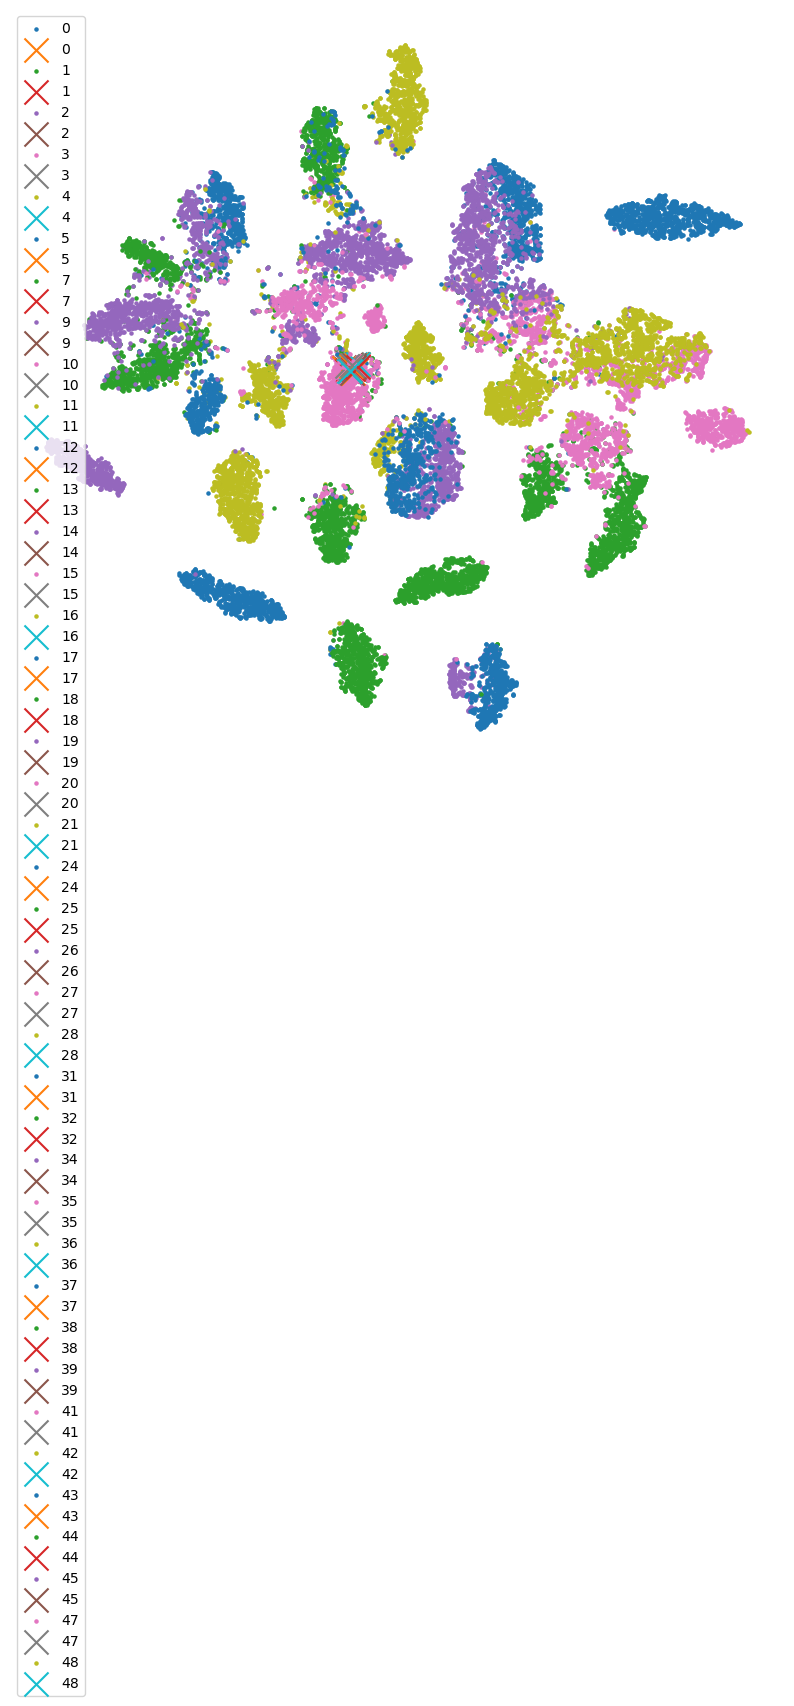

In [23]:
# seen class tsne

plt.figure(figsize=(10, 10),dpi=100)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
for index, cla in enumerate(train_label_unique):
    class_index = np.where(train_label == cla)[0].tolist()

    plt.scatter(train_feat_tsne[class_index,0], train_feat_tsne[class_index,1],   s=5, label=cla)
    plt.scatter(att_tsne[cla,0], att_tsne[cla,1],  s=300, marker='x', label=cla)
    #plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[index], s=300, marker='*', label=cla)
    #plt.scatter(all_semantic_tsne[cla,0], all_semantic_tsne[cla,1],  c=cs[index], s=300, marker='x', label=cla)
    
plt.legend() 
#plt.title('With_Center_Loss_Lambda_{}. Star(*): centers, X: semantic attributes'.format(0.0001))
# plt.savefig(f'figure/figure{postfix}.png')
    #plt.annotate(test_id_unseen[i], xy = (vec_tsne[i][0], vec_tsne[i][1]), xytext = (vec_tsne[i][0]+0.1, vec_tsne[i][1]+0.1))



In [20]:
att_tsne

array([[-21.07377  ,   2.3687422],
       [-18.338102 ,   5.1231027],
       [-24.112026 ,   4.9813523],
       [-22.446423 ,   5.51551  ],
       [-19.739492 ,   4.5404763],
       [-20.322111 ,   4.7835865],
       [-20.842497 ,   2.5621977],
       [-19.30591  ,   5.2555256],
       [-24.080996 ,   4.4246006],
       [-19.915157 ,   5.256866 ],
       [-21.314651 ,   6.155888 ],
       [-21.154392 ,   5.3211684],
       [-18.299768 ,   6.372876 ],
       [-22.886543 ,   3.2842999],
       [-18.633053 ,   6.20456  ],
       [-21.717424 ,   2.2785597],
       [-19.349777 ,   3.5927844],
       [-24.077002 ,   4.52786  ],
       [-22.715178 ,   2.940148 ],
       [-19.202145 ,   3.456598 ],
       [-21.853859 ,   2.9077742],
       [-19.530792 ,   6.081945 ],
       [-21.272833 ,   3.4558449],
       [-23.612478 ,   5.053589 ],
       [-19.12238  ,   3.4077551],
       [-21.18335  ,   4.880201 ],
       [-21.41623  ,   5.589401 ],
       [-22.60834  ,   3.0343482],
       [-21.411324 ,

In [14]:
att2 = mat_semantic['att'].T

In [44]:
# 检验seen class的相似度 based on semantic output
sapce_dim = 50  # shape[0] stands for the num of classes to be decice
hit = []
label_predict = {i:[] for i in range(50)}
for index, feat in enumerate(all_semantic):
    diff = np.tile(feat, (sapce_dim, 1)) - centers   # Subtract element-wise
    squaredDiff = diff ** 2  # squared for the subtract
    squaredDist = np.sum(squaredDiff, axis=1)  # sum is performed by row
    distance = squaredDist ** 0.5

    max_index = np.argsort(distance)
    label = int(max_index[0])
    
    log = f'real_label:{index}, predict:{label}'
    if index in test_id_unseen:
        log+= ' unseen'
    else:
        if index!=label:
            log += f'seen but miss, {max_index[0]}, {distance[max_index[0]]}, {max_index[1]}, {distance[max_index[1]]}, {max_index[2]}, {distance[max_index[2]]}'
        hit.append(index==label)
    print(log)

print("total hit:", np.sum(hit), np.sum(hit)/40)
#  1e-5-0.87929, 1e-6-0.38, 1e-8-0.2286

real_label:0, predict:0
real_label:1, predict:1
real_label:2, predict:2
real_label:3, predict:3
real_label:4, predict:4
real_label:5, predict:5
real_label:6, predict:48 unseen
real_label:7, predict:7
real_label:8, predict:17 unseen
real_label:9, predict:5seen but miss, 5, 9.771903038024902, 32, 12.207999229431152, 9, 12.832351684570312
real_label:10, predict:10
real_label:11, predict:34seen but miss, 34, 9.588922500610352, 47, 12.3328218460083, 26, 12.990621566772461
real_label:12, predict:12
real_label:13, predict:13
real_label:14, predict:14
real_label:15, predict:15
real_label:16, predict:16
real_label:17, predict:17
real_label:18, predict:18
real_label:19, predict:19
real_label:20, predict:20
real_label:21, predict:21
real_label:22, predict:48 unseen
real_label:23, predict:35 unseen
real_label:24, predict:24
real_label:25, predict:25
real_label:26, predict:26
real_label:27, predict:27
real_label:28, predict:28
real_label:29, predict:34 unseen
real_label:30, predict:0 unseen
real_la

In [97]:
# 检验linear model 的聚类效果
cl = CenterLoss(num_classes=50, feat_dim=2048)
cl.load_state_dict(torch.load('output/AWA2/CenterLoss.pth'))

linear = LinearModel(2048)
linear.load_state_dict(torch.load('output/AWA2/LinearModel.pth'))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
# seen class
transferred_feature = linear(torch.tensor(test_feature_seen).float())
tsne = TSNE()
transferred_feature_tsne = tsne.fit_transform(transferred_feature.detach().cpu().numpy()) #进行数据降维,并返回结果
tsne = TSNE()
test_feature_seen_tsne =  tsne.fit_transform(test_feature_seen)

In [99]:
# seen class
from sklearn import metrics

sil_score = metrics.silhouette_score(test_feature_seen, test_label_seen, metric='euclidean')
sil_score2 = metrics.silhouette_score(transferred_feature.detach().cpu().numpy(), test_label_seen, metric='euclidean')

cal_score = metrics.calinski_harabaz_score(test_feature_seen, test_label_seen)
cal_score2 = metrics.calinski_harabaz_score(transferred_feature.detach().cpu().numpy(), test_label_seen)


/home/zzc/anaconda3/envs/bert/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/home/zzc/anaconda3/envs/bert/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


In [98]:
# unseen class
transferred_feature = linear(torch.tensor(test_feature_unseen).float())
tsne = TSNE()
transferred_feature_tsne = tsne.fit_transform(transferred_feature.detach().cpu().numpy()) #进行数据降维,并返回结果
tsne = TSNE()
test_feature_unseen_tsne =  tsne.fit_transform(test_feature_unseen)

In [88]:
# unseen class
from sklearn import metrics

sil_score = metrics.silhouette_score(test_feature_unseen, test_label_unseen, metric='euclidean')
sil_score2 = metrics.silhouette_score(transferred_feature.detach().cpu().numpy(), test_label_unseen, metric='euclidean')

cal_score = metrics.calinski_harabaz_score(test_feature_unseen, test_label_unseen)
cal_score2 = metrics.calinski_harabaz_score(transferred_feature.detach().cpu().numpy(), test_label_unseen)


/home/zzc/anaconda3/envs/bert/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/home/zzc/anaconda3/envs/bert/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


In [100]:
sil_score

0.06756238038009282

In [101]:
sil_score2

0.36992612

In [102]:
cal_score

72.66029208716017

In [219]:
cal_score2

NameError: name 'cal_score2' is not defined

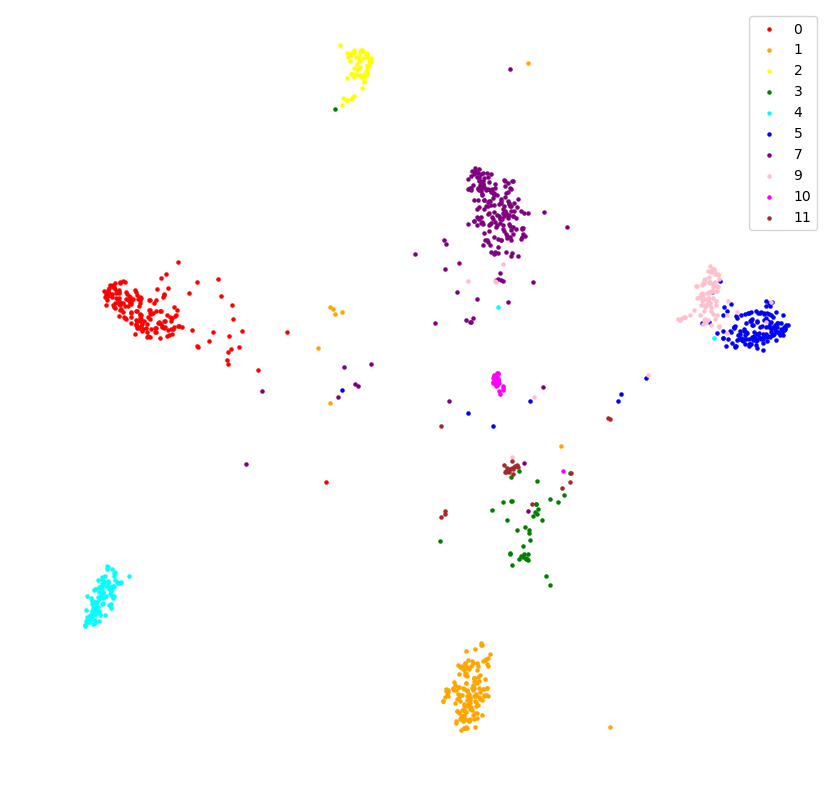

In [104]:
# unseen class tsne on linear mapping with center loss guidance

plt.figure(figsize=(10, 10),dpi=100)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
for index, cla in enumerate(train_label_unique[:10]): # unseen:test_id_unseen, seen: train_label_unique[:10]
    class_index = np.where(test_label_seen == cla)[0].tolist()
    
    plt.scatter(transferred_feature_tsne[class_index,0], transferred_feature_tsne[class_index,1],  c=cs[index], s=5, label=cla)
    #plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[index], s=300, marker='*', label=cla)
    #plt.scatter(all_semantic_tsne[cla,0], all_semantic_tsne[cla,1],  c=cs[index], s=300, marker='x', label=cla)
    
plt.legend() 
#plt.title('With_Center_Loss_Lambda_{}. Star(*): centers, X: semantic attributes'.format(0.0001))
# plt.savefig(f'figure/figure{postfix}.png')
    #plt.annotate(test_id_unseen[i], xy = (vec_tsne[i][0], vec_tsne[i][1]), xytext = (vec_tsne[i][0]+0.1, vec_tsne[i][1]+0.1))



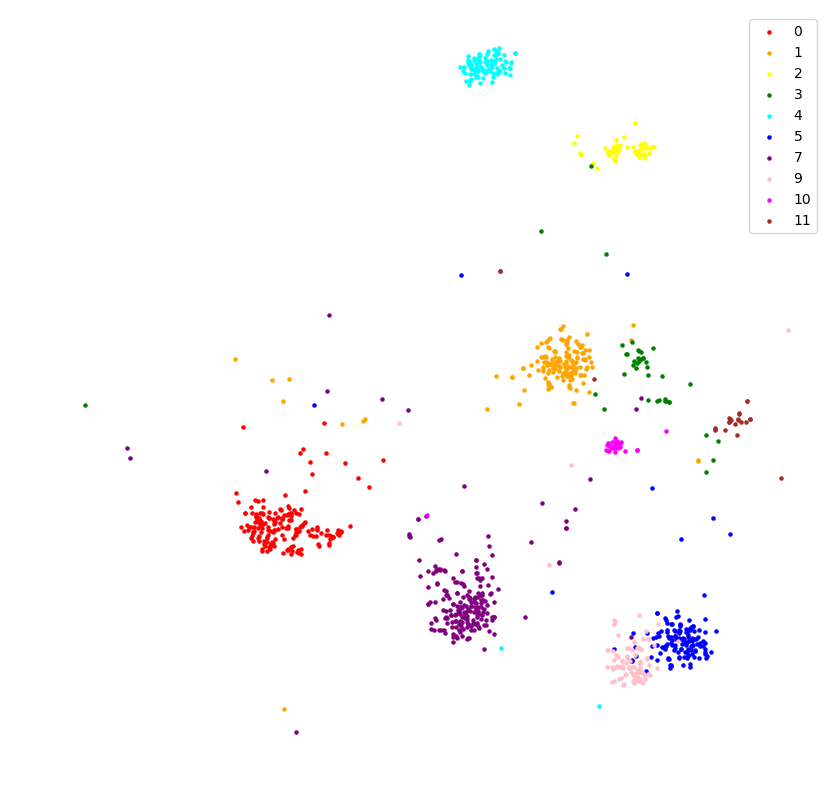

In [106]:
# original feature of unseen class tsne 

plt.figure(figsize=(10, 10),dpi=100)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
for index, cla in enumerate(train_label_unique[:10]): # unseen:test_id_unseen, seen: train_label_unique[:10]
    class_index = np.where(test_label_seen == cla)[0].tolist()
    
    plt.scatter(test_feature_seen_tsne[class_index,0], test_feature_seen_tsne[class_index,1],  c=cs[index], s=5, label=cla)
    #plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[index], s=300, marker='*', label=cla)
    #plt.scatter(all_semantic_tsne[cla,0], all_semantic_tsne[cla,1],  c=cs[index], s=300, marker='x', label=cla)
    
plt.legend() 
#plt.title('With_Center_Loss_Lambda_{}. Star(*): centers, X: semantic attributes'.format(0.0001))
# plt.savefig(f'figure/figure{postfix}.png')
    #plt.annotate(test_id_unseen[i], xy = (vec_tsne[i][0], vec_tsne[i][1]), xytext = (vec_tsne[i][0]+0.1, vec_tsne[i][1]+0.1))



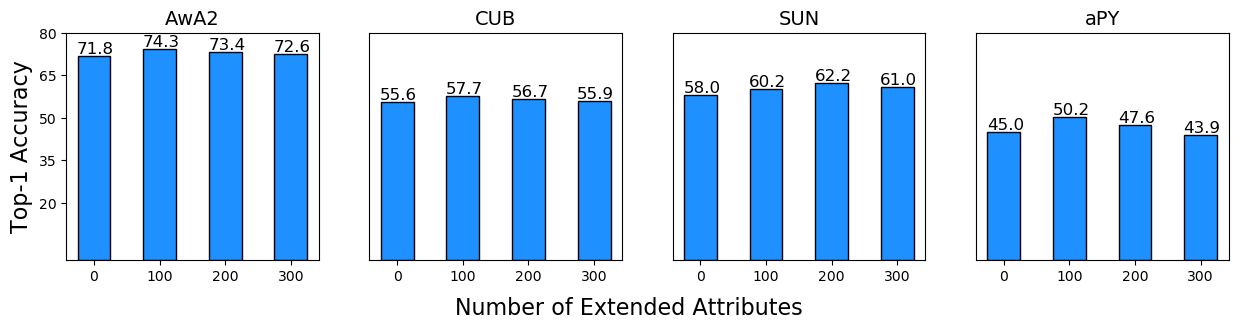

In [185]:
# plot performance of attributes num 
def mul(a):
    return [aa*100 for aa in a]

# attrnum = [0, 50, 100, 150, 200, 300]
# cub = [0.55578, 0.554, 0.573, 0.5719, 0.5669, 0.5588]
# awa2 = [0.71, 0.74346, 0.741438, 0.7402, 0.7341, 0.72602]
# sun = [0.6097, 0.6076, 0.6083, 0.621, 0.607639, 0.610417]
# apy = [0.30, 0.4596, 0.4433, 0.4261, 0.3811, 0.3156]
attrnum = [0, 100, 200, 300]
cub = [0.556,  0.577,  0.5669, 0.5588]
awa2 = [0.718, 0.743438, 0.7341, 0.72602]
sun = [0.58, 0.602,  0.622, 0.610417]
apy = [0.45,  0.502, 0.476, 0.439]

dictt = {
    0:awa2,
    1:cub,
    2:sun,
    3:apy
}
cs = ['red','black','brown','blue','cyan']
# plt.figure(figsize=(10, 7),dpi=500)
# plt.plot(attrnum, mul(awa2),marker='s', c=cs[0], label ='AWA2',)
# plt.plot(attrnum, mul(cub),marker='s', c=cs[1], label ='CUB')
# plt.plot(attrnum, mul(sun),marker='s', c=cs[2], label ='SUN')
# plt.plot(attrnum, mul(apy),marker='s', c=cs[3], label ='APY')

plt.figure(figsize=(15, 3),dpi=100)

# awa2
i= 0
plt.subplot(1, 4, 1)
plt.bar(attrnum, height=mul(awa2), width=50, color='#1E90FF',edgecolor='black')
plt.yticks((np.linspace(20, 80, 5)))
for x, y in zip(attrnum, mul(dictt[i])):
    plt.text(x-26, y+0.8, s=round(y,1), fontsize=12)
#plt.xlabel("AwA2",fontsize=14)
plt.ylabel("Top-1 Accuracy",fontsize=16)
plt.title("AwA2", fontsize=14)

# cub
i+=1
plt.subplot(1, 4, 2)
plt.bar(attrnum,  height=mul(cub), width=50, color='#1E90FF',edgecolor='black')
plt.yticks((np.linspace(20, 80, 5)))
for x, y in zip(attrnum, mul(dictt[i])):
    plt.text(x-26, y+0.8, s=round(y,1), fontsize=12)
frame = plt.gca()
# y 轴不可见
frame.axes.get_yaxis().set_visible(False)
plt.title("CUB", fontsize=14)

# sun
i+=1
plt.subplot(1, 4, 3)
plt.bar(attrnum,  height=mul(sun), width=50, color='#1E90FF',edgecolor='black')
plt.yticks((np.linspace(20, 80, 5)))
for x, y in zip(attrnum, mul(dictt[i])):
    plt.text(x-26, y+0.8, s=round(y,1), fontsize=12)
frame = plt.gca()
# y 轴不可见
frame.axes.get_yaxis().set_visible(False)
plt.title("SUN", fontsize=14)

# apy
i+=1    
plt.subplot(1, 4, 4)
plt.bar(attrnum, height=mul(apy), width=50, color='#1E90FF',edgecolor='black')
plt.yticks((np.linspace(20, 80, 5)))
for x, y in zip(attrnum, mul(dictt[i])):
    plt.text(x-26, y+0.8, s=round(y,1), fontsize=12)
frame = plt.gca()
# y 轴不可见
frame.axes.get_yaxis().set_visible(False)
plt.title("aPY", fontsize=14)

# for x, y in zip(attrnum, mul(dictt[i])):
#     plt.text(x-9, y+0.8, s=round(y,1), fontsize=16)
    
# for i in range(4):
#     #plt.scatter(attrnum, mul(dictt[i]), c=cs[i], marker='s')
#     for x, y in zip(attrnum, mul(dictt[i])):
#         plt.text(x-9, y+0.8, s=round(y,1), fontsize=16)

#plt.title("Performance on Attributes Number",fontsize=30)

# plt.grid()
#plt.ylabel("Accuracy",fontsize=20)
#plt.legend(loc='lower right', prop={'size': 10})

plt.suptitle("Number of Extended Attributes",fontsize=16, y=0)
plt.savefig("attr_performance.png", bbox_inches='tight',orientation='landscape')
plt.show()


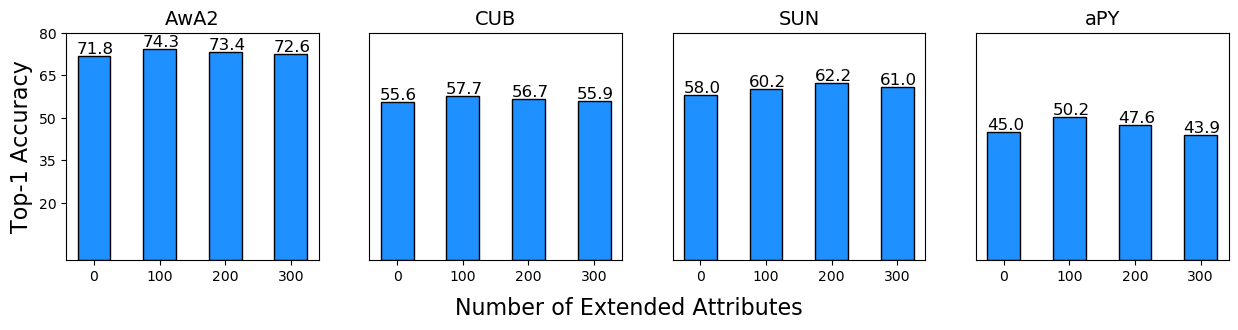

In [186]:
from PIL import Image
display(Image.open('attr_performance.png'))

In [214]:
# file1 = 'output/AWA2/LOG/Log_C_W-0.0_GenAttr-100_Seed_9195.log' # no center
# file2 = 'output/AWA2/LOG/Log_C_W-0.0001_GenAttr-150_Seed_9550.log' # 0.0001 center

file1 = 'output/AWA2/LOG/Log_C_W-0.0_GenAttr-200_Seed_6816.log' # no center
file2 = 'output/AWA2/LOG/Log_C_W-0.0001_GenAttr-150_Seed_3678.log' # 0.0001 center


log1 = [l.strip() for l in open(file1).readlines()][2:]
log2 = [l.strip() for l in open(file2).readlines()][2:]

# zsl1 = [0]
# zsl2 = [0]
zsl1 = []
zsl2 = []
for l in log1[::2]:
    zsl1.append(round(float(l.split('\t')[1]), 4))
for l in log2[::2]:
    zsl2.append(round(float(l.split('\t')[1]), 4))


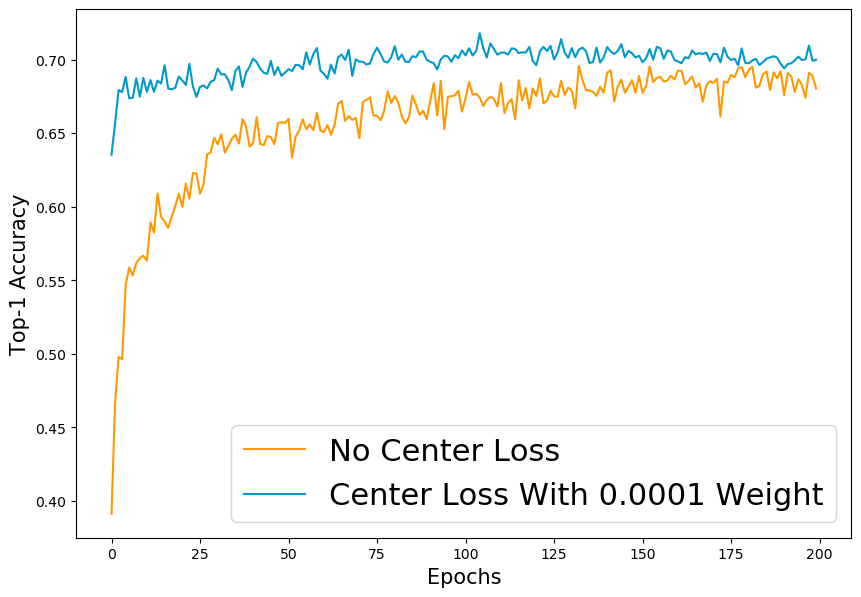

In [218]:

plt.figure(figsize=(10,7),dpi=100)
x =list(range(len(zsl1)))

plt.plot(x, zsl1, label='No Center Loss', c='#FF9900')
plt.plot(x, zsl2, label='Center Loss With 0.0001 Weight',c='#0099CC')


plt.plot()
#plt.ylim(0.4, 0.)8
#plt.axhline(max(zsl2),ls="-",c="#40E0D0")#添加垂直直线
#plt.axhline(max(zsl1),ls="-",c="#FFA500")#添加垂直直线

plt.legend(loc='lower right',fontsize=22)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Top-1 Accuracy",fontsize=15)

plt.savefig("center_loss_performance.png", bbox_inches='tight',orientation='landscape')
plt.show()

In [84]:
log1

['0\t0.40073297106028055\t0.40073297106028055\t0.8748653531074524\t0.0\t0.8748653531074524',
 'gzsl: seen=0.5736, unseen=0.1110, h=0.1859\tgzsl: seen=0.5736, unseen=0.1110, h=0.1859',
 '1\t0.42487046632124353\t0.42487046632124353\t0.8632357120513916\t0.0\t0.8632357120513916',
 'gzsl: seen=0.6260, unseen=0.0878, h=0.1540\tgzsl: seen=0.5736, unseen=0.1110, h=0.1859',
 '2\t0.4457222292430178\t0.4457222292430178\t0.8503890633583069\t0.0\t0.8503890633583069',
 'gzsl: seen=0.6544, unseen=0.0900, h=0.1582\tgzsl: seen=0.5736, unseen=0.1110, h=0.1859',
 '3\t0.4488815872614685\t0.4488815872614685\t0.8426315784454346\t0.0\t0.8426315784454346',
 'gzsl: seen=0.6647, unseen=0.0899, h=0.1583\tgzsl: seen=0.5736, unseen=0.1110, h=0.1859',
 '4\t0.45494755465689374\t0.45494755465689374\t0.8061856031417847\t0.0\t0.8061856031417847',
 'gzsl: seen=0.6722, unseen=0.0871, h=0.1542\tgzsl: seen=0.5736, unseen=0.1110, h=0.1859',
 '5\t0.4702388474661949\t0.4702388474661949\t0.8283259272575378\t0.0\t0.828325927257

(-0.5, 4.5, 2.5, -0.5)

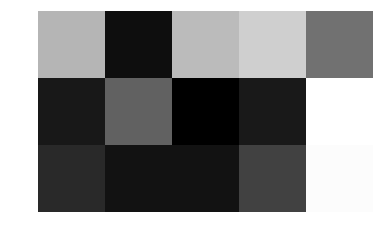

In [272]:
plt.imshow(matrix[:, 3:], interpolation='nearest', cmap='gist_yarg' )
plt.axis("off")

In [276]:
ex_matrix = matrix[:, 3:]

In [350]:
for ind, i in enumerate(ex_matrix):
    for j in i:
        print(round(j, 1), end=' ')
    print()
    


0.2 2.2 0.1 -0.2 1.0 
2.1 1.2 2.4 2.1 -0.8 
1.9 2.2 2.2 1.6 -0.7 


0.15649287
2.223477
0.08909166
-0.15528904
0.98696816
2.1006756
1.194748
2.4041433
2.0735905
-0.7606544
1.8759382
2.1631734
2.1674433
1.5879139
-0.71320564


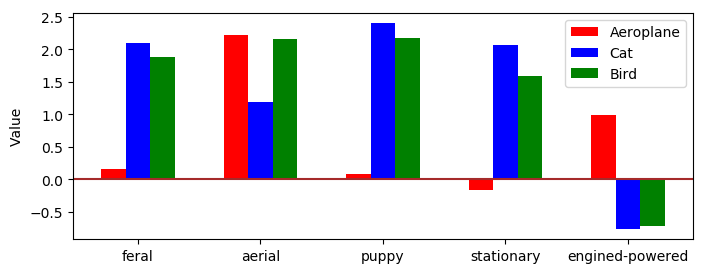

In [347]:
import matplotlib.pyplot as plt
import matplotlib
# 设置中文字体和负号正常显示
# matplotlib.rcParams['font.sans-serif'] = ['SimHei']
# matplotlib.rcParams['axes.unicode_minus'] = False
cs = ['red','blue','green','green','cyan',
      'blue','purple','pink','magenta','brown']
# cs = ['87 105 60', '82 75 46', '171 92 37']
label_list = ['feral', 'aerial', 'puppy', 'stationary','engined-powered']    # 横坐标刻度显示值
class_label = ['Aeroplane', 'Cat', 'Bird']
# num_list1 = [20, 30, 15, 35]      # 纵坐标值1
# num_list2 = [15, 30, 40, 20]      # 纵坐标值2

plt.figure(figsize=(8, 3),dpi=100)
"""
绘制条形图
left:长条形中点横坐标
height:长条形高度
width:长条形宽度，默认值0.8
label:为后面设置legend准备
"""
bar = []
for i in range(3):
    for j in range(5):
        x = (j+1)*0.5+(i+1)*0.1
        print(ex_matrix[i][j])
        this_bar = plt.bar(x, height=ex_matrix[i][j], width=0.1, color=cs[i], label=class_label[i])
    bar.append(this_bar)
plt.axhline(y=0,ls="-",c="brown")#添加水平直线
# plt.axvline(x=4,ls="-",c="green")#添加垂直直线
#plt.ylim(0, 5)     # y轴取值范围
plt.ylabel("Value")
"""
设置x轴刻度显示值
参数一：中点坐标
参数二：显示值
"""

plt.xticks([index*0.5+0.7  for index in range(5)], label_list, rotation=0)
#plt.xlabel("Extended Attributes")
#plt.title("某某公司")
plt.legend([bar[0], bar[1], bar[2]],['Aeroplane', 'Cat', 'Bird'])     # 设置题注
# 编辑文本
# for rect in rects1:
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
# for rect in rects2:
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
plt.show()